# Decision Tree

The objective of this lab is to understand Decision Trees for classification tasks, followed by an implementation of Decision Trees using ID3 Algorithm from scratch.

## What is a Decision Tree?

A Decision Tree is a supervised machine learning algorithm used for both classification and regression tasks. 

It models decisions and their possible consequences as a tree structure. 

Decision Trees break down a dataset into smaller subsets while at the same time incrementally developing an associated decision tree.

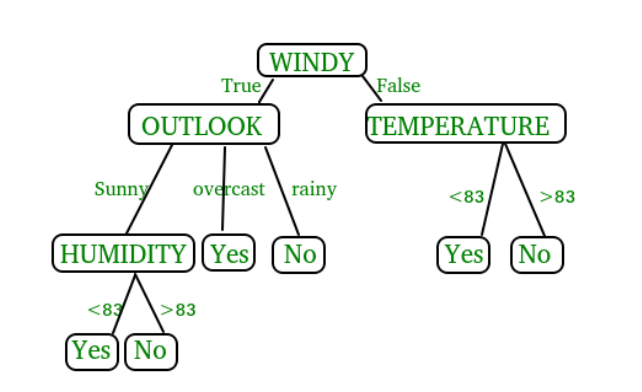

## Some basic terminologies

1. Root Node: The root node represents the entire dataset and is split based on the best feature.
2. Branch Nodes: Internal nodes that represent decision points, where the data is split based on a specific attribute.
3. Leaf Nodes: Final categorization or prediction-representing terminal nodes.
4. Attribute Selection: The process of choosing the most informative attribute for each split.
5. Splitting Criteria: Metrics like information gain, entropy, or the Gini Index are used to calculate the optimal split.

## Node Splitting

Decision Trees use different criteria to decide how to split nodes. The two most common are:

1. Gini Index: Measures the impurity or the probability of a randomly chosen element being incorrectly classified.

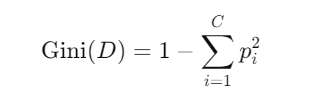

2. Entropy: Entropy measures the disorder or uncertainty in the dataset.

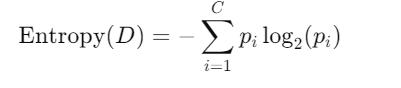

Information Gain is the reduction in entropy after the dataset is split on an attribute.

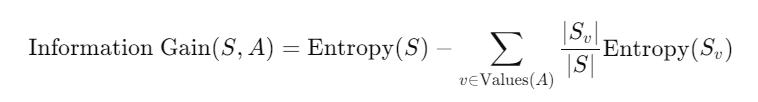

## ID3 Algorithm 

The ID3 algorithm is a common decision tree algorithm to select the attribute that splits the data best. 

It follows these steps:

1. Calculate entropy for the dataset.
2. For each attribute:
    Calculate the entropy after splitting the dataset based on the attribute.
    Calculate the information gain for the attribute.
3. Select the attribute with the highest information gain.
4. Split the dataset based on the selected attribute and repeat the process recursively for each child node.
5. Stop the recursion when either all data belongs to the same class, or there are no more attributes to split.

## Step-wise implementation 

### 1. Prepare the dataset

In [324]:
# Importing libraries
import pandas as pd 
import numpy as np 

In [325]:
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

In [326]:
df = pd.DataFrame(data)
print(df)

     Outlook Temperature Humidity    Wind PlayTennis
0      Sunny         Hot     High    Weak         No
1      Sunny         Hot     High  Strong         No
2   Overcast         Hot     High    Weak        Yes
3       Rain        Mild     High    Weak        Yes
4       Rain        Cool   Normal    Weak        Yes
5       Rain        Cool   Normal  Strong         No
6   Overcast        Cool   Normal  Strong        Yes
7      Sunny        Mild     High    Weak         No
8      Sunny        Cool   Normal    Weak        Yes
9       Rain        Mild   Normal    Weak        Yes
10     Sunny        Mild   Normal  Strong        Yes
11  Overcast        Mild     High  Strong        Yes
12  Overcast         Hot   Normal    Weak        Yes
13      Rain        Mild     High  Strong         No


### 2. Calculating the entropy of the whole dataset

In [327]:
def calc_total_entropy(df, label, class_list):
    total_row = df.shape[0] #the total size of the dataset
    total_entr = 0
    
    for c in class_list: #for each class in the label
        total_class_count = df[df[label] == c].shape[0] #number of the class
        total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row) #entropy of the class
        total_entr += total_class_entr #adding the class entropy to the total entropy of the dataset
    
    return total_entr

### 3. Calculating the entropy for each feature

In [328]:
def calc_entropy(feature_value_data, label, class_list):
    class_count = feature_value_data.shape[0]
    entropy = 0
    
    for c in class_list:
        label_class_count = feature_value_data[feature_value_data[label] == c].shape[0] #row count of class c 
        entropy_class = 0
        if label_class_count != 0:
            probability_class = label_class_count/class_count #probability of the class
            entropy_class = - probability_class * np.log2(probability_class)  #entropy
        entropy += entropy_class
    return entropy

### 4. Calculating information gain for each feature

In [329]:
def calc_info_gain(feature_name, df, label, class_list):
    feature_value_list = df[feature_name].unique() #unqiue values of the feature
    total_row = df.shape[0]
    feature_info = 0.0
    
    for feature_value in feature_value_list:
        feature_value_data = df[df[feature_name] == feature_value] #filtering rows with that feature_value
        feature_value_count = feature_value_data.shape[0]
        feature_value_entropy = calc_entropy(feature_value_data, label, class_list) #calculcating entropy for the feature value
        feature_value_probability = feature_value_count/total_row
        feature_info += feature_value_probability * feature_value_entropy #calculating information of the feature value
        
    return calc_total_entropy(df, label, class_list) - feature_info #calculating information gain by subtracting

### 5. Finding the Feature with highest Information Gain

In [330]:
def find_most_informative_feature(df, label, class_list):
    feature_list = df.columns.drop(label) #finding the feature names in the dataset
                                            #N.B. label is not a feature, so dropping it
    max_info_gain = -1
    max_info_feature = None
    
    for feature in feature_list:  #for each feature in the dataset
        feature_info_gain = calc_info_gain(feature, df, label, class_list)
        if max_info_gain < feature_info_gain: #selecting feature name with highest information gain
            max_info_gain = feature_info_gain
            max_info_feature = feature
            
    return max_info_feature

### 6. Adding node to the tree

As we have found the feature name with the highest information gain, we have to generate a node in the tree and its value as a branch. 

Split the dataset based on the selected attribute and repeat the process recursively for each child node.

- If any value of the feature represents only one class then the feature value represents a pure class

- If the value does not represent a pure value, we have to extend it further until we find a pure class.

In [331]:
def generate_sub_tree(feature_name, df, label, class_list):
    feature_value_count_dict = df[feature_name].value_counts(sort=False) #dictionary of the count of unqiue feature value
    tree = {} #sub tree or node
    for feature_value, count in feature_value_count_dict.items():
        feature_value_data = df[df[feature_name] == feature_value] #dataset with only feature_name = feature_value
        
        assigned_to_node = False #flag for tracking feature_value is pure class or not
        for c in class_list: #for each class
            class_count = feature_value_data[feature_value_data[label] == c].shape[0] #count of class c

            if class_count == count: #count of (feature_value = count) of class (pure class)
                tree[feature_value] = c #adding node to the tree
                df = df[df[feature_name] != feature_value] #removing rows with feature_value
                assigned_to_node = True
        if not assigned_to_node: #not pure class
            tree[feature_value] = "?" #as feature_value is not a pure class, it should be expanded further, 
                                      #so the branch is marking with ?
            
    return tree, df

### 7. Performing ID3 Algorithm and generating Tree

1. The task is to find the most informative feature

2. Making a tree node with a feature name and feature values as branches
- If pure class, adding leaf node (= Class) to the tree node
- If impure class, adding an expandable node (= ‘?’) to the tree node

3. Shrinking/Updating the dataset according to the pure class

4. Adding the node with branches into a tree

5. Expand the branch of the next impure class (= ‘?’) with an updated dataset

The recursion endpoint when:

- The dataset becomes empty after updating

- There is no expandable branch (= all pure class)

In [332]:
def make_tree(root, prev_feature_value, df, label, class_list):
    if df.shape[0] != 0: #if dataset becomes enpty after updating
        max_info_feature = find_most_informative_feature(df, label, class_list) #most informative feature
        tree, df = generate_sub_tree(max_info_feature, df, label, class_list) #getting tree node and updated dataset
        next_root = None
        
        if prev_feature_value != None: #add to intermediate node of the tree
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree
            next_root = root[prev_feature_value][max_info_feature]
        else: #add to root of the tree
            root[max_info_feature] = tree
            next_root = root[max_info_feature]
        
        for node, branch in list(next_root.items()): #iterating the tree node
            if branch == "?": #if it is expandable
                feature_value_data = df[df[max_info_feature] == node] #using the updated dataset
                make_tree(next_root, node, feature_value_data, label, class_list) #recursive call with updated dataset


### 8. Starting the algorithm

We can start calling the recursive tree building algorithm of ID3 after finding the class names.

The complete tree would look like:

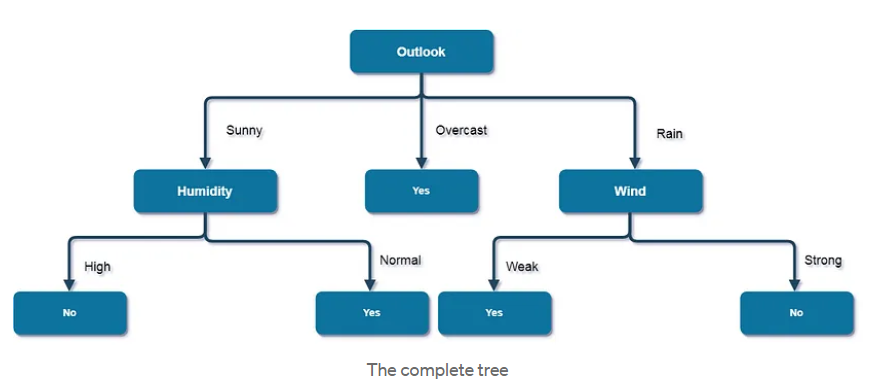

In [333]:
def id3(df, label):
#     train_data = df.copy() #getting a copy of the dataset
    tree = {} #tree which will be updated
    class_list = df[label].unique() #getting unqiue classes of the label
    make_tree(tree, None, df, label, class_list) #start calling recursion
    return tree

In [334]:
tree = id3(df, 'PlayTennis')
print(tree)

{'Outlook': {'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}}, 'Overcast': 'Yes', 'Rain': {'Wind': {'Weak': 'Yes', 'Strong': 'No'}}}}


Note the type of tree traversal being used for printing the tree nodes and values.

## Predicting from the tree

The tree has been generated!

Now, we can use the tree for prediction. We will recursively traverse the nested dictionary until any leaf node (= class) is found.

In [335]:
def predict(tree, instance):
    if not isinstance(tree, dict): #if it is leaf node
        return tree #return the value
    else:
        root_node = next(iter(tree)) #getting first key/feature name of the dictionary
        feature_value = instance[root_node] #value of the feature
        if feature_value in tree[root_node]: #checking the feature value in current tree node
            return predict(tree[root_node][feature_value], instance) #goto next feature
        else:
            return None

## Evaluating test dataset

In [336]:
test_data = {
    'Outlook': ['Sunny', 'Overcast', 'Rain', 'Sunny'],
    'Temperature': ['Cool', 'Hot', 'Mild', 'Mild'],
    'Humidity': ['Normal', 'High', 'High', 'Normal'],
    'Wind': ['Weak', 'Weak', 'Strong', 'Strong'],
    'PlayTennis': ['Yes', 'Yes', 'No', 'Yes']
}

test_data = pd.DataFrame(test_data)


In [337]:
def evaluate(tree, test_data, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index, row in test_data.iterrows(): #for each row in the dataset
        result = predict(tree, test_data.iloc[index]) #predict the row
        if result == test_data[label].iloc[index]: #predicted value and expected value is same or not
            correct_preditct += 1 #increase correct count
        else:
            wrong_preditct += 1 #increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct) #calculating accuracy
    return accuracy

In [338]:
accuracy = evaluate(tree, test_data, 'PlayTennis') #evaluating the test dataset
print(accuracy)

1.0
